In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, TimeDistributed, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from collections import Counter
import gc
import splitfolders

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
import splitfolders
import os

# Define paths
data_dir = './datasets/'  # Adjusted to a relative path
output_dir = './datasets_split'  # Removed trailing comma

# Create directories if they don't exist (optional)
os.makedirs(data_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

# Perform the split
splitfolders.ratio(data_dir, output=output_dir, seed=1337, ratio=(.8, 0.15, 0.05))


In [3]:
# Enhanced data augmentation with better parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,          # Reduced for better stability
    width_shift_range=0.1,      # Reduced
    height_shift_range=0.1,     # Reduced
    horizontal_flip=True,
    zoom_range=0.1,             # Reduced
    brightness_range=[0.9, 1.1], # Added brightness variation
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_dir = "./datasets_split/train"
test_dir = "./datasets_split/test"
val_dir = "./datasets_split/val"

In [4]:
# Optimized image size and batch size
IMG_SIZE = 128  # Increased back for better feature extraction
BATCH_SIZE = 16  # Increased for better gradient estimates

In [5]:
train_batches = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
)

test_batches = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

val_batches = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Check class distribution
print("Class indices:", train_batches.class_indices)
print("Number of training samples:", train_batches.samples)
print("Number of validation samples:", val_batches.samples)
print("Number of test samples:", test_batches.samples)

Found 33434 images belonging to 2 classes.
Found 2091 images belonging to 2 classes.
Found 6268 images belonging to 2 classes.
Class indices: {'Drowsy': 0, 'Non Drowsy': 1}
Number of training samples: 33434
Number of validation samples: 6268
Number of test samples: 2091


In [6]:
# Preview images
images, labels = next(train_batches)
print(f"Shape of batch: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Label distribution in batch: {np.bincount(labels.astype(int))}")


Shape of batch: (16, 128, 128, 3)
Labels shape: (16,)
Label distribution in batch: [7 9]


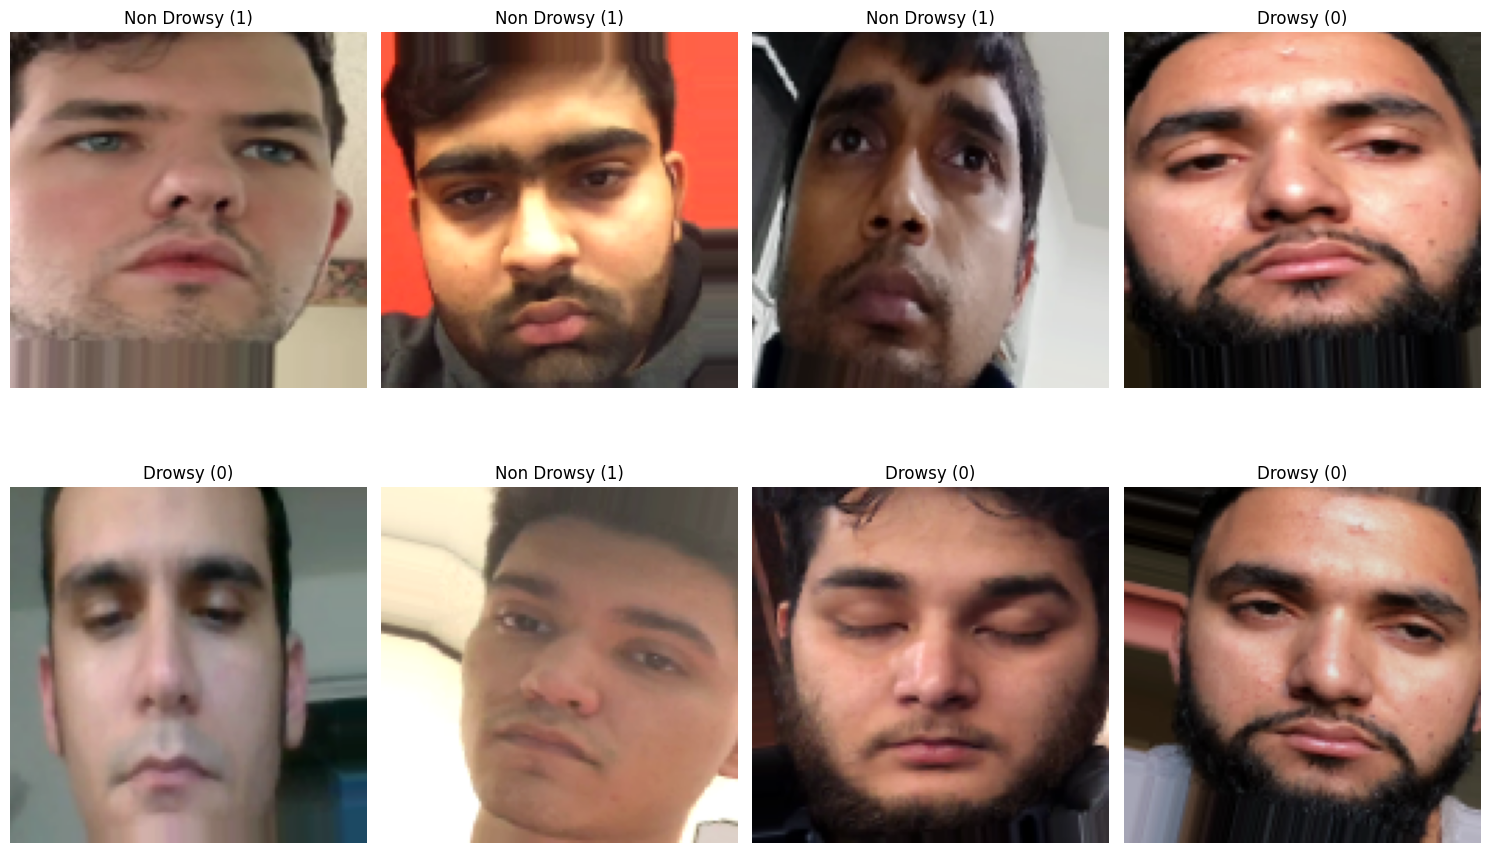

In [7]:
plt.figure(figsize=(15, 10))
for i in range(min(8, len(images))):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    label = int(labels[i])
    label_name = list(train_batches.class_indices.keys())[list(train_batches.class_indices.values()).index(label)]
    plt.title(f'{label_name} ({label})')

plt.tight_layout()
plt.show()

In [8]:
# Configure GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth configured")
    except RuntimeError as e:
        print(f"GPU configuration error: {e}")

In [9]:
# Create Transfer Learning Model with MobileNetV2
print("Creating Transfer Learning Model...")

base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model initially
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile model with optimized parameters
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=BinaryCrossentropy(label_smoothing=0.1),
    metrics=['accuracy', 'precision', 'recall']
)

model.summary()

Creating Transfer Learning Model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 8s 1us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,435,905 (9.29 MB)

 Trainable params: 175,105 (684.00 KB)

 Non-trainable params: 2,260,800 (8.62 MB)

In [10]:
# Setup callbacks for better training
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Training parameters
EPOCHS = 50
steps_per_epoch = len(train_batches)
validation_steps = len(val_batches)

print(f"Training steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

# Phase 1: Initial Training (Frozen Base Model)
print("Phase 1: Training with frozen base model...")
history = model.fit(
    train_batches,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_batches,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Training steps per epoch: 2090
Validation steps: 392
Phase 1: Training with frozen base model...


e:\python\deteksi-kelelahan\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8164 - loss: 0.4888 - precision: 0.8017 - recall: 0.7980
Epoch 1: val_accuracy improved from -inf to 0.99282, saving model to best_model.h5


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 2412s 1s/step - accuracy: 0.8164 - loss: 0.4888 - precision: 0.8017 - recall: 0.7981 - val_accuracy: 0.9928 - val_loss: 0.2300 - val_precision: 0.9884 - val_recall: 0.9962 - learning_rate: 0.0010
Epoch 2/50
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9510 - loss: 0.3016 - precision: 0.9497 - recall: 0.9435
Epoch 2: val_accuracy improved from 0.99282 to 0.99553, saving model to best_model.h5


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 528s 253ms/step - accuracy: 0.9510 - loss: 0.3016 - precision: 0.9497 - recall: 0.9435 - val_accuracy: 0.9955 - val_loss: 0.2185 - val_precision: 0.9925 - val_recall: 0.9979 - learning_rate: 0.0010
Epoch 3/50
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9636 - loss: 0.2804 - precision: 0.9634 - recall: 0.9569
Epoch 3: val_accuracy improved from 0.99553 to 0.99729, saving model to best_model.h5


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 532s 255ms/step - accuracy: 0.9636 - loss: 0.2804 - precision: 0.9634 - recall: 0.9569 - val_accuracy: 0.9973 - val_loss: 0.2144 - val_precision: 0.9962 - val_recall: 0.9979 - learning_rate: 0.0010
Epoch 4/50
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9744 - loss: 0.2645 - precision: 0.9729 - recall: 0.9719
Epoch 4: val_accuracy improved from 0.99729 to 0.99761, saving model to best_model.h5


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 513s 245ms/step - accuracy: 0.9744 - loss: 0.2645 - precision: 0.9729 - recall: 0.9719 - val_accuracy: 0.9976 - val_loss: 0.2129 - val_precision: 0.9973 - val_recall: 0.9976 - learning_rate: 0.0010
Epoch 5/50
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9773 - loss: 0.2586 - precision: 0.9770 - recall: 0.9743
Epoch 5: val_accuracy improved from 0.99761 to 0.99825, saving model to best_model.h5


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 530s 253ms/step - accuracy: 0.9773 - loss: 0.2586 - precision: 0.9770 - recall: 0.9743 - val_accuracy: 0.9982 - val_loss: 0.2099 - val_precision: 0.9983 - val_recall: 0.9979 - learning_rate: 0.0010
Epoch 6/50
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9806 - loss: 0.2532 - precision: 0.9810 - recall: 0.9770
Epoch 6: val_accuracy did not improve from 0.99825
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 513s 245ms/step - accuracy: 0.9806 - loss: 0.2532 - precision: 0.9810 - recall: 0.9770 - val_accuracy: 0.9971 - val_loss: 0.2105 - val_precision: 0.9956 - val_recall: 0.9983 - learning_rate: 0.0010
Epoch 7/50
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9839 - loss: 0.2489 - precision: 0.9848 - recall: 0.9807
Epoch 7: val_accuracy improved from 0.99825 to 0.99856, saving model to best_model.h5


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 509s 244ms/step - accuracy: 0.9839 - loss: 0.2489 - precision: 0.9848 - recall: 0.9807 - val_accuracy: 0.9986 - val_loss: 0.2057 - val_precision: 0.9986 - val_recall: 0.9983 - learning_rate: 0.0010
Epoch 8/50
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9827 - loss: 0.2487 - precision: 0.9837 - recall: 0.9794
Epoch 8: val_accuracy improved from 0.99856 to 0.99872, saving model to best_model.h5


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 516s 247ms/step - accuracy: 0.9827 - loss: 0.2487 - precision: 0.9837 - recall: 0.9794 - val_accuracy: 0.9987 - val_loss: 0.2058 - val_precision: 0.9986 - val_recall: 0.9986 - learning_rate: 0.0010
Epoch 9/50
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9848 - loss: 0.2468 - precision: 0.9832 - recall: 0.9841
Epoch 9: val_accuracy did not improve from 0.99872
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 506s 242ms/step - accuracy: 0.9848 - loss: 0.2468 - precision: 0.9832 - recall: 0.9841 - val_accuracy: 0.9984 - val_loss: 0.2064 - val_precision: 0.9986 - val_recall: 0.9979 - learning_rate: 0.0010
Epoch 10/50
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9878 - loss: 0.2422 - precision: 0.9879 - recall: 0.9860
Epoch 10: val_accuracy improved from 0.99872 to 0.99904, saving model to best_model.h5


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 529s 253ms/step - accuracy: 0.9878 - loss: 0.2422 - precision: 0.9879 - recall: 0.9860 - val_accuracy: 0.9990 - val_loss: 0.2055 - val_precision: 0.9990 - val_recall: 0.9990 - learning_rate: 0.0010
Epoch 11/50
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9854 - loss: 0.2441 - precision: 0.9847 - recall: 0.9841
Epoch 11: val_accuracy improved from 0.99904 to 0.99920, saving model to best_model.h5


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 513s 245ms/step - accuracy: 0.9854 - loss: 0.2441 - precision: 0.9847 - recall: 0.9841 - val_accuracy: 0.9992 - val_loss: 0.2046 - val_precision: 0.9993 - val_recall: 0.9990 - learning_rate: 0.0010
Epoch 12/50
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9872 - loss: 0.2412 - precision: 0.9874 - recall: 0.9850
Epoch 12: val_accuracy improved from 0.99920 to 0.99936, saving model to best_model.h5


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 505s 242ms/step - accuracy: 0.9872 - loss: 0.2412 - precision: 0.9874 - recall: 0.9850 - val_accuracy: 0.9994 - val_loss: 0.2039 - val_precision: 0.9997 - val_recall: 0.9990 - learning_rate: 0.0010
Epoch 13/50
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9871 - loss: 0.2416 - precision: 0.9869 - recall: 0.9859
Epoch 13: val_accuracy did not improve from 0.99936
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 534s 256ms/step - accuracy: 0.9871 - loss: 0.2416 - precision: 0.9869 - recall: 0.9859 - val_accuracy: 0.9990 - val_loss: 0.2049 - val_precision: 0.9990 - val_recall: 0.9990 - learning_rate: 0.0010
Epoch 14/50
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9867 - loss: 0.2400 - precision: 0.9865 - recall: 0.9850
Epoch 14: val_accuracy did not improve from 0.99936
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 565s 270ms/step - accuracy: 0.9867 - loss: 0.2400 - precision: 0.9865 - recall: 0.9850 - val_accuracy: 0.9990 - val_loss: 0.2049 - val_precision: 0.999

In [11]:
# Phase 2: Fine-tuning (Unfreeze Base Model)
print("\nPhase 2: Fine-tuning with unfrozen base model...")

# Unfreeze the base model
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers) - 20

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Much lower learning rate
    loss=BinaryCrossentropy(label_smoothing=0.1),
    metrics=['accuracy', 'precision', 'recall']
)

# Continue training with fine-tuning
fine_tune_epochs = 20
total_epochs = len(history.history['accuracy']) + fine_tune_epochs

history_fine = model.fit(
    train_batches,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_batches,
    validation_steps=validation_steps,
    epochs=total_epochs,
    initial_epoch=len(history.history['accuracy']),
    callbacks=callbacks,
    verbose=1
)



Phase 2: Fine-tuning with unfrozen base model...
Epoch 28/47
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 846ms/step - accuracy: 0.9656 - loss: 0.2729 - precision: 0.9651 - recall: 0.9609
Epoch 28: val_accuracy did not improve from 0.99936
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 1952s 925ms/step - accuracy: 0.9656 - loss: 0.2729 - precision: 0.9651 - recall: 0.9609 - val_accuracy: 0.9994 - val_loss: 0.2053 - val_precision: 0.9993 - val_recall: 0.9993 - learning_rate: 1.0000e-04
Epoch 29/47
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.9921 - loss: 0.2287 - precision: 0.9927 - recall: 0.9904
Epoch 29: val_accuracy improved from 0.99936 to 0.99952, saving model to best_model.h5


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 1008s 482ms/step - accuracy: 0.9921 - loss: 0.2287 - precision: 0.9927 - recall: 0.9904 - val_accuracy: 0.9995 - val_loss: 0.2016 - val_precision: 1.0000 - val_recall: 0.9990 - learning_rate: 1.0000e-04
Epoch 30/47
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9938 - loss: 0.2234 - precision: 0.9946 - recall: 0.9920
Epoch 30: val_accuracy improved from 0.99952 to 0.99968, saving model to best_model.h5


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 981s 469ms/step - accuracy: 0.9938 - loss: 0.2234 - precision: 0.9946 - recall: 0.9920 - val_accuracy: 0.9997 - val_loss: 0.2006 - val_precision: 1.0000 - val_recall: 0.9993 - learning_rate: 1.0000e-04
Epoch 31/47
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.9959 - loss: 0.2202 - precision: 0.9953 - recall: 0.9959
Epoch 31: val_accuracy did not improve from 0.99968
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 1089s 521ms/step - accuracy: 0.9959 - loss: 0.2202 - precision: 0.9953 - recall: 0.9959 - val_accuracy: 0.9997 - val_loss: 0.2008 - val_precision: 1.0000 - val_recall: 0.9993 - learning_rate: 1.0000e-04
Epoch 32/47
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9970 - loss: 0.2177 - precision: 0.9968 - recall: 0.9968
Epoch 32: val_accuracy did not improve from 0.99968
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 611s 292ms/step - accuracy: 0.9970 - loss: 0.2177 - precision: 0.9968 - recall: 0.9968 - val_accuracy: 0.9997 - val_loss: 0.1999 - val_precisi

2090/2090 ━━━━━━━━━━━━━━━━━━━━ 621s 297ms/step - accuracy: 0.9986 - loss: 0.2136 - precision: 0.9987 - recall: 0.9983 - val_accuracy: 0.9998 - val_loss: 0.1996 - val_precision: 1.0000 - val_recall: 0.9997 - learning_rate: 1.0000e-04
Epoch 36/47
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9984 - loss: 0.2126 - precision: 0.9981 - recall: 0.9983
Epoch 36: val_accuracy did not improve from 0.99984
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 607s 290ms/step - accuracy: 0.9984 - loss: 0.2126 - precision: 0.9981 - recall: 0.9983 - val_accuracy: 0.9998 - val_loss: 0.1999 - val_precision: 1.0000 - val_recall: 0.9997 - learning_rate: 1.0000e-04
Epoch 37/47
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9983 - loss: 0.2124 - precision: 0.9979 - recall: 0.9984
Epoch 37: val_accuracy did not improve from 0.99984
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 608s 291ms/step - accuracy: 0.9983 - loss: 0.2124 - precision: 0.9979 - recall: 0.9984 - val_accuracy: 0.9997 - val_loss: 0.1996 - val_precisio

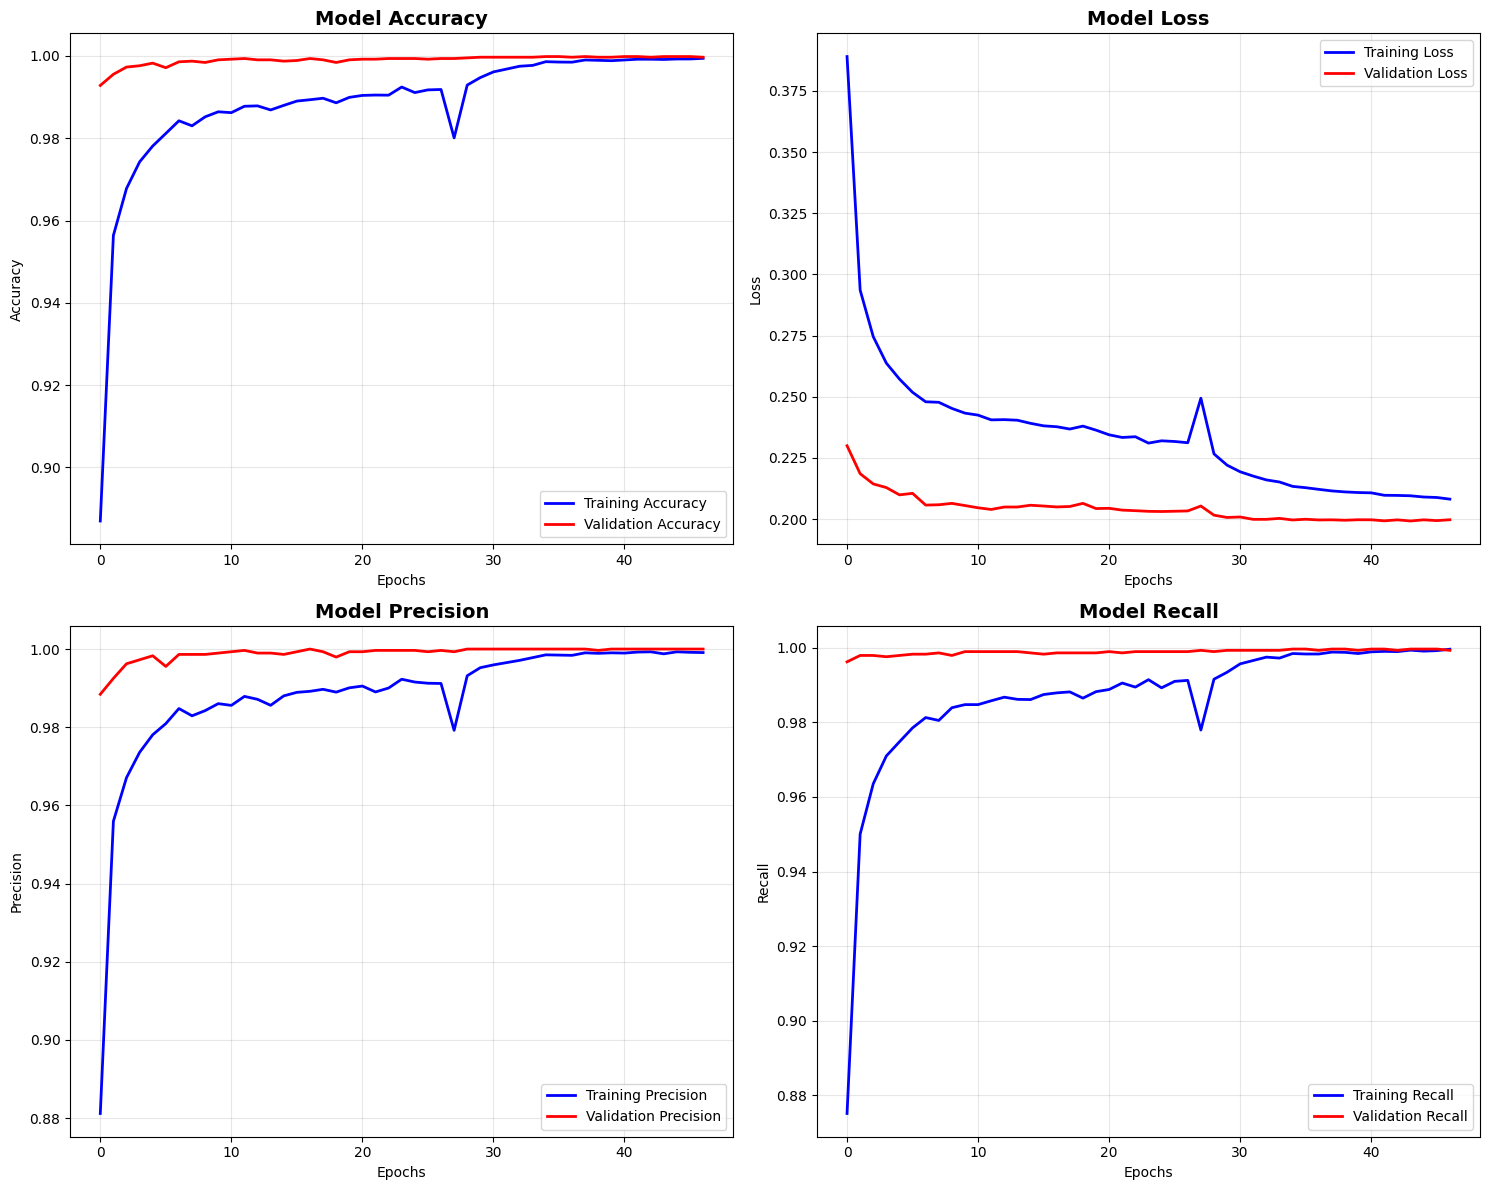

In [12]:
# Combine training histories
for key in history.history:
    history.history[key].extend(history_fine.history[key])

# Plot comprehensive training history
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    epochs_range = range(len(history.history['accuracy']))
    
    # Accuracy Plot
    axes[0,0].plot(epochs_range, history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    axes[0,0].plot(epochs_range, history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    axes[0,0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Epochs')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Loss Plot
    axes[0,1].plot(epochs_range, history.history['loss'], 'b-', label='Training Loss', linewidth=2)
    axes[0,1].plot(epochs_range, history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[0,1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Epochs')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Precision Plot
    axes[1,0].plot(epochs_range, history.history['precision'], 'b-', label='Training Precision', linewidth=2)
    axes[1,0].plot(epochs_range, history.history['val_precision'], 'r-', label='Validation Precision', linewidth=2)
    axes[1,0].set_title('Model Precision', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Epochs')
    axes[1,0].set_ylabel('Precision')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Recall Plot
    axes[1,1].plot(epochs_range, history.history['recall'], 'b-', label='Training Recall', linewidth=2)
    axes[1,1].plot(epochs_range, history.history['val_recall'], 'r-', label='Validation Recall', linewidth=2)
    axes[1,1].set_title('Model Recall', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Epochs')
    axes[1,1].set_ylabel('Recall')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)


Evaluating model on test data...
131/131 ━━━━━━━━━━━━━━━━━━━━ 52s 388ms/step

Test Results:
Test Accuracy: 0.9995 (99.95%)
Test Loss: 0.1994

Classification Report:
              precision    recall  f1-score   support

      Drowsy       1.00      1.00      1.00      1118
  Non Drowsy       1.00      1.00      1.00       973

    accuracy                           1.00      2091
   macro avg       1.00      1.00      1.00      2091
weighted avg       1.00      1.00      1.00      2091



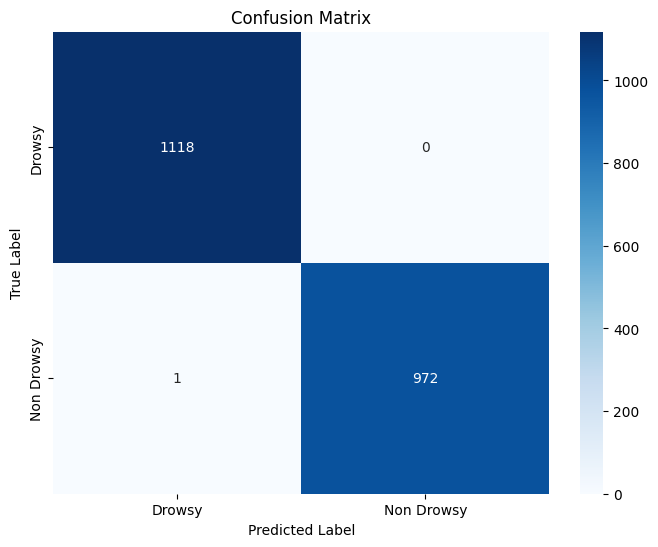


FINAL RESULTS
Best Validation Accuracy: 0.9998 (99.98%)
Final Test Accuracy: 0.9995 (99.95%)
🎉 SUCCESS! Achieved target accuracy of 80% or higher!

Model saved as 'final_improved_model.h5'
Training completed successfully!


In [13]:
# Comprehensive model evaluation
def evaluate_model(model, test_generator):
    print("Evaluating model on test data...")
    
    # Get predictions
    test_generator.reset()
    predictions = model.predict(test_generator, verbose=1)
    y_pred = (predictions > 0.5).astype(int).flatten()
    
    # Get true labels
    y_true = test_generator.classes
    
    # Calculate metrics
    test_results = model.evaluate(test_generator, verbose=0)
    test_accuracy = test_results[1]  # accuracy is the second metric
    test_loss = test_results[0]
    
    print(f"\nTest Results:")
    print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"Test Loss: {test_loss:.4f}")
    
    # Classification report
    class_names = list(test_generator.class_indices.keys())
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return test_accuracy, predictions

# Evaluate the final model
final_accuracy, predictions = evaluate_model(model, test_batches)

# Display final results
print(f"\n{'='*50}")
print(f"FINAL RESULTS")
print(f"{'='*50}")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f} ({max(history.history['val_accuracy'])*100:.2f}%)")
print(f"Final Test Accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")

if final_accuracy >= 0.8:
    print("🎉 SUCCESS! Achieved target accuracy of 80% or higher!")
else:
    print(f"Target not reached. Current accuracy: {final_accuracy*100:.2f}%")
    print("\nTips for further improvement:")
    print("- Ensure dataset quality and balance")
    print("- Try different pre-trained models (EfficientNet, ResNet)")
    print("- Adjust hyperparameters (learning rate, dropout rates)")
    print("- Collect more diverse training data")

# Save the final model
model.save('final_improved_model.h5')
print("\nModel saved as 'final_improved_model.h5'")

# Clean up memory
gc.collect()
print("Training completed successfully!")


In [20]:
# --- 6. Simpan Model ---
MODEL_SAVE_PATH = 'driver_fatigue_detection_model.h5'
try:
    model.save(MODEL_SAVE_PATH)
    print(f"\nModel berhasil disimpan di: {MODEL_SAVE_PATH}")
except Exception as e:
    print(f"Error saat menyimpan model: {e}")


Model berhasil disimpan di: driver_fatigue_detection_model.h5
